# GoogLeNet

In this section of Lab02, GoogLeNet model was implemented on the CIFAR-10 dataset. With the same data set, 2 versions of GoogLeNet were employed namely,

1. GoogLeNet from scratch (GoogLeNet)
2. Pretrained GoogLeNet

Since the given architechture of GoogLeNet was not the same as what can be found on the original paper and also does not suit out problem (a 10-class classification problem), the modification of the architechture was necessary. The modification includes:

e.g.
* The number of output (from 1000 to  10 classes)
* The input image size
* The addition of a convolutional layer at pre_layers
* The padding
* Replacement of BatchNorm2d to Local-Response Normalization
* The addition of the two auxiliary layers
* The losses of auxiliary layers
* etc.

The two versions were impleneted with the exact same optimizer as well as the loss functions and they are as follows:

* criterion = nn.CrossEntropyLoss()
* optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The number of trainable parameters of each model are as follows:

1. GoogLeNet has 10,635,134 trainable parameters
2. Pretrained GooLeNet has 6,624,904 trainable parameters

The models were both trained for 10 epochs with the batch size of 4 and their performace at the 10th epoch are:

* GoogLeNet: Train acc = 91.58% , Val acc = 96.62% , Test acc = 86.77%
* Pretrained GoogLeNet: Train acc = 97.98% , Val acc = 99.40% , Test acc = 93.60%

NOTE: The comparison between GoogLeNet and AlexNet on CIFAR-10 and the comparison between GoogLeNet and Pretrained GoogLeNet can be found in the discussion section

TASK: Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
   1. Use the same backbone (input image size, convolutions, etc.) before the first Inception module
   2. Add the two side classifiers

#### Libaries

In [23]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

### 1. Prepare data set

In [24]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) #### NOTE FOR PRETRAIN

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 2. Define Models

#### 2.1 Inception Block

In [25]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
            

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1) # <<<< dim 1 = channel

#### 2.2 Auxiliary Layers

In [26]:
class Aux_layer(nn.Module):
    def __init__(self, position):    
        super(Aux_layer, self).__init__()
        
        self.avgpool = nn.AvgPool2d(5, stride=3) 
        self.position = position
        
        if self.position == 'a4':
            self.conv = nn.Sequential(nn.Conv2d(512,128,kernel_size = 1,stride = 1), nn.ReLU(True))   
        else:
            self.conv = nn.Sequential(nn.Conv2d(528,128,kernel_size = 1,stride = 1), nn.ReLU(True))   

        self.fc1 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(True), nn.Dropout(0.7))
        self.fc2 = nn.Linear(1024, 10)
    
    def forward(self,x):
        aux = self.avgpool(x)
        aux = self.conv(aux)
#         print(f'aux conv: {aux.shape}')
        aux = aux.flatten(start_dim = 1)
#         print(f'aux: {aux.shape}')
        aux = self.fc1(aux)
        aux = self.fc2(aux)
        return aux

#### 2.3 GoogLeNet

In [27]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        self.is_debug = False
        
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=7, stride =2, padding =3),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride =2, padding = 1),
            nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(64, 192, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(True),
            nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),              
            nn.MaxPool2d(3, stride =2, padding =1),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool= nn.AvgPool2d(7, stride=1) ## orig = 8
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, 10)
        
        self.aux_a4 = Aux_layer('a4')
        self.aux_d4 = Aux_layer('d4')
    
    def forward(self, x):
        out = self.pre_layers(x)
        
        if self.is_debug : print(f'pre-layer: {out.shape}')
            
        out = self.a3(out)
        if self.is_debug : print(f'a3: {out.shape}')
            
        out = self.b3(out)
        if self.is_debug : print(f'b3 :{out.shape}')
            
        out = self.maxpool(out)
        if self.is_debug : print(f'maxpool: {out.shape}')
            
        out = self.a4(out)
        if self.is_debug : print(f'a4: {out.shape}')
            
        aux_a4 = self.aux_a4(out)
        out = self.b4(out)
        if self.is_debug : print(f'b4 : {out.shape}')
            
        out = self.c4(out)
        if self.is_debug : print(f'c4 : {out.shape}') 
            
        out = self.d4(out)
        if self.is_debug : print(f'd4 : {out.shape}')
            
        aux_d4 = self.aux_d4(out)
        out = self.e4(out)
        if self.is_debug : print(f'e4 : {out.shape}')
            
        out = self.maxpool(out)
        if self.is_debug : print(f'maxpool : {out.shape}')
            
        out = self.a5(out)
        if self.is_debug : print(f'a5 : {out.shape}')
            
        out = self.b5(out)
        if self.is_debug : print(f'b5 : {out.shape}')
            
        out = self.avgpool(out)
        if self.is_debug : print(f'avgpool : {out.shape}')
            
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        if self.training == True:
            return out, aux_a4, aux_d4
        else:
            return out


### 3. Define Train and Evaluation Functions

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        if (epoch+1) % 5 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_a4, aux_d4 = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_a4, labels)
                        loss3 = criterion(aux_d4, labels)
                        loss = loss1 + 0.3*(loss2+loss3)
#                     elif is_inception and weights_name == 'GoogLeNet' and phase == 'val':
#                         outputs, _, _ = model(inputs) #,_,_ or in the forward()
#                         loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs) #,_,_ or in the forward()
                        loss = criterion(outputs, labels)            
                    
                    outputs = nn.functional.softmax(outputs, dim=1)        
                    _, preds = torch.max(outputs, 1) # returns (values, indices)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start
            
            if (epoch+1) % 5 == 0:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                print("Epoch time taken: ", elapsed_epoch)
    
            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

#         print()

    # Output summary statistics, load the best weight set, and return results
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [29]:
def evaluate(model, iterator, criterion,model_name):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
                
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

In [30]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

### 4. Train the models

#### 4.1 Define models to train

In [43]:
googlenet = GoogLeNet()
googlenet_pre = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True, aux_logits = True)
#change the last output to be 10 classes
googlenet_pre.fc = nn.Linear(1024,10)
models = [googlenet, googlenet_pre]
model_names = ['GoogLeNet', 'Pretrained GoogLeNet']
# models = [googlenet_pre]
# model_names = ['Pretrained GoogLeNet']

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


#### 4.2 Loss and Optimizer Functions

In [44]:
criterion = nn.CrossEntropyLoss()

optimizers = []
for model in models:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizers.append(optimizer)

#### 4.2 Move everything to the configured device

##### Let's check the availability of GPU...

In [45]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:1


In [46]:
for model in models:
    model = model.to(device)
    
criterion = criterion.to(device)

#### 4.3 Count the parameters

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i,model in enumerate(models):
    print(f'The model {model_names[i]} has {count_parameters(model):,} trainable parameters')# Train the model

The model GoogLeNet has 10,635,134 trainable parameters
The model Pretrained GoogLeNet has 11,990,138 trainable parameters


#### 4.4 Prepare the dataloader

In [36]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

#### 4.5 Train the models

Training: GoogLeNet
Epoch 4/9
----------
train Loss: 0.9656 Acc: 0.8094
Epoch time taken:  1312.412663936615
val Loss: 0.3936 Acc: 0.8636
Epoch time taken:  1387.3063054084778
Epoch 9/9
----------
train Loss: 0.4886 Acc: 0.9158
Epoch time taken:  1246.7739770412445
val Loss: 0.1084 Acc: 0.9662
Epoch time taken:  1339.1904847621918
Training complete in 228m 49s
Best val Acc: 0.966200


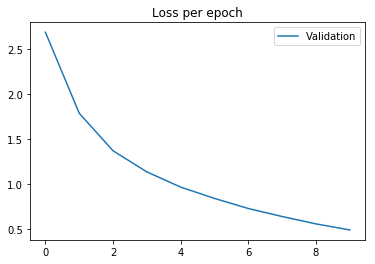

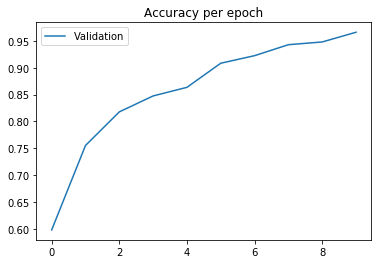

In [20]:
print(f'Training: {model_names[0]}')
best_model, val_acc_history, loss_acc_history = train_model(models[0], dataloaders, criterion, optimizers[0], 10, model_names[0],is_inception=True )
plot_data(val_acc_history, loss_acc_history)

Training: Pretrained GoogLeNet
Epoch 4/9
----------
train Loss: 0.4255 Acc: 0.9400
Epoch time taken:  1023.3844466209412
val Loss: 0.0772 Acc: 0.9757
Epoch time taken:  1086.9910814762115
Epoch 9/9
----------
train Loss: 0.1957 Acc: 0.9798
Epoch time taken:  1048.2613151073456
val Loss: 0.0192 Acc: 0.9940
Epoch time taken:  1116.5802915096283
Training complete in 179m 42s
Best val Acc: 0.994000


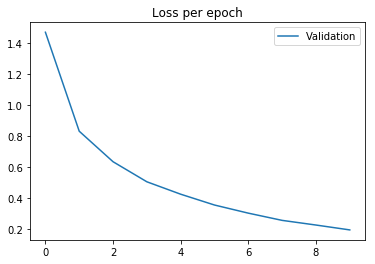

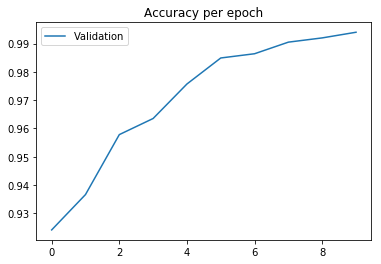

In [38]:
print(f'Training: {model_names[1]}')
best_model, val_acc_history, loss_acc_history = train_model(models[1], dataloaders, criterion, optimizers[1], 10, model_names[1],is_inception=True )
plot_data(val_acc_history, loss_acc_history)

### 5. Results

In [39]:
for i, model in enumerate(models):
    print(f'Model: {model_names[i]}')
    model.load_state_dict(torch.load(f'{model_names[i]}.pth'))
    test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model, test_dataloader, criterion, model_names[i])
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Model: GoogLeNet
Test Loss: 0.408 | Test Acc: 86.77%
Model: Pretrained GoogLeNet
Test Loss: 0.238 | Test Acc: 93.60%
